In [3]:
import csvg
import json
import bz2
import numpy as np
from collections import defaultdict
import datetime

In [4]:
N_BINS = 67

def load_timestamps(path='data/url-sample-201408-201501/unigram-fb5d-gt2-20topic-model-spider_when.csv'):
    reader = iter(csv.reader(open(path)))
    next(reader)
    return dict((k, datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S+00:00")) for k, v in reader)


def load_histograms(path='data/url-sample-201408-201501/unigram-fb5d-gt2-20topic-model-predictions.csv.bz2',
                    n_topics=20, min_prop=0.1, domain_grouper=lambda x: x, time_grouper=lambda x: 1):
    hist = defaultdict(lambda: np.zeros((N_BINS, n_topics)))
    for row in csv.DictReader(bz2.BZ2File(path)):
        dgrp = domain_grouper(row['url_signature__base_domain'])
        if dgrp is False:
            continue
        tgrp = time_grouper(row['id'])
        bin = int(row['fb_binned_5d'])
        topics = [k for k, v in json.loads(row['topics']) if v >= min_prop]
        hist[dgrp, tgrp][bin, topics] += 1
    return hist

try:
    timestamp_lookup
except NameError:
    timestamp_lookup = load_timestamps()

    
def group_by_week(doc_id):
    return '{0}-{1}'.format(*timestamp_lookup[doc_id].isocalendar())


def group_by_day(doc_id):
    return timestamp_lookup[doc_id].strftime('%Y-%m-%d')


IN_DOMAINS = {'smh.com.au', 'theage.com.au', 'news.com.au', 'dailytelegraph.com.au', 'theaustralian.com.au', 'heraldsun.com.au'}

%time histograms = load_histograms(time_grouper=group_by_week, \
                                   domain_grouper=IN_DOMAINS.__contains__, \
                                   min_prop=.3)

CPU times: user 17.2 s, sys: 86.8 ms, total: 17.3 s
Wall time: 17.3 s


In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

In [6]:
def norm_histogram(h, low=7, high=40):
    h = (h / h.sum(axis=0))
    h[low] = h[:low + 1].sum(axis=0)
    h[high] = h[high:].sum(axis=0)
    return h[low:high + 1]



/n/schwafs/home/joel/ves/likeable/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


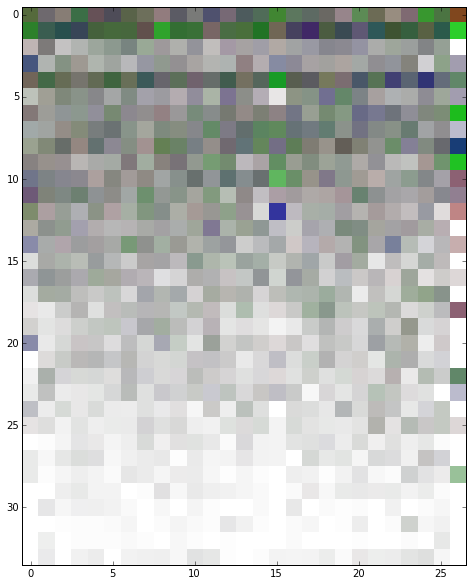

In [7]:
_, dates = zip(*sorted(histograms))

from matplotlib.colors import LinearSegmentedColormap
cdict = {'red': [(0, 1, 1), (1, 1, 1)],
         'green': [(0,0,0), (1,0,0)],
         'blue': [(0,0,0), (1,0,0)],
         'alpha': [(0,0,0), (1,.8,.8)]}
cm_red_alpha = LinearSegmentedColormap('RedAlpha', cdict)
cdict = {'red': [(0, 0, 0), (1, 0, 0)],
         'green': [(0,0,0), (1,0,0)],
         'blue': [(0,1,1), (1,1,1)],
         'alpha': [(0,0,0), (1,.8,.8)]}
cm_blue_alpha = LinearSegmentedColormap('BlueAlpha', cdict)
cdict = {'red': [(0, 0, 0), (1, 0, 0)],
         'green': [(0,1,1), (1,1,1)],
         'blue': [(0,0,0), (1,0,0)],
         'alpha': [(0,0,0), (1,.8,.8)]}
cm_green_alpha = LinearSegmentedColormap('GreenAlpha', cdict)

X = np.array([norm_histogram(histograms[True, dt])
              for dt in dates
              if histograms[True, dt].sum() > 50])

plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(X[..., 0]), interpolation='nearest', cmap=cm_red_alpha)
plt.imshow(np.transpose(X[..., 2]), interpolation='nearest', cmap=cm_blue_alpha)
plt.imshow(np.transpose(X[..., 4]), interpolation='nearest', cmap=cm_green_alpha)

[  3  31  11  27  11  22   8 503  16  56   8  38  11   1  20  15  31  56
   2  48]


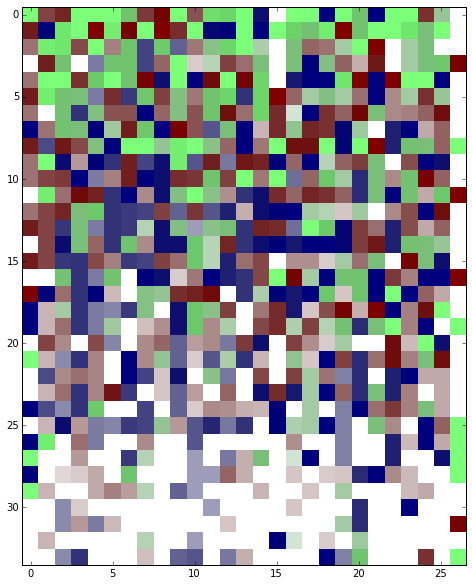

In [8]:
print(np.bincount(X.argmax(axis=-1).flat))
SEL_TOPICS = [17, 16, 1, ] #5, 19]
plt.figure(figsize=(30, 10))
plt.imshow(np.nanargmax(X[..., SEL_TOPICS], axis=-1).T, interpolation='nearest', cmap='jet')
# white alpha overlay
cdict = {'red': [(0, 1, 1), (1, 1, 1)],
         'green': [(0,1,1), (1,1,1)],
         'blue': [(0,1,1), (1,1,1)],
         'alpha': [(0,1,1), (.3,0,0), (1,0,0)]}
cm_white_alpha = LinearSegmentedColormap('WhiteRAlpha', cdict)
plt.imshow(np.nanmax(X[..., SEL_TOPICS], axis=-1).T, interpolation='nearest', cmap=cm_white_alpha)

In [9]:

from sklearn.externals import joblib
SAMPLE_DIR = 'data/url-sample-201301-201606-aupubs-headlines'
LDA_PASS = 1
vec = joblib.load(SAMPLE_DIR + '/unigram-vectorizer-fb5d-gt2.pkl')
lda = joblib.load(SAMPLE_DIR + '/unigram-fb5d-gt2-{:02d}topic-model-{}pass.pkl'.format(6, LDA_PASS))
feature_names = np.asarray(vec.get_feature_names())
topic_freqs = np.log10(lda.state.sstats.sum(axis=1))
order = np.argsort(topic_freqs)
print(zip(order, topic_freqs.take(order)))

[(0, 6.1066489041244063), (4, 6.1802562731812021), (2, 6.2158971627542092), (3, 6.2501022875850527), (5, 6.2614781765573282), (1, 6.3133652825815449)]


In [10]:

import re

def group_headlines(path=SAMPLE_DIR + '/titles-for-fairfax-and-newsltd.csv.bz2',
                    bin_grouper=lambda x: x, time_grouper=lambda x: 1):
    out = defaultdict(list)
    try:
        for row in csv.DictReader(bz2.BZ2File(path)):
            bin = bin_grouper(max(int(row['fb_binned_5d'] or '0'), int(row['fb_binned_longterm'] or '0')))
            if bin is not None:
                dt = datetime.datetime.strptime(re.sub('\.[0-9]+', '', row['spider_when']), "%Y-%m-%d %H:%M:%S+00:00")
                out[time_grouper(dt), bin].append(row['downloaded__headline'])
    except EOFError:
        # XXX remove me
        pass
    return {k: '\n'.join(v) for k, v in out.items()}


BIN_MAP = np.zeros(69, dtype=int)
prev = 0
for i, x in enumerate(range(9, 39, 3)):
    BIN_MAP[prev:x] = i
    prev = x
BIN_MAP[prev:] = i
N_BINS = len(np.unique(BIN_MAP))
assert N_BINS == 10

grouped_headlines = group_headlines(time_grouper=lambda dt: dt.strftime('%Y-%m'),
                                    bin_grouper=lambda x: BIN_MAP[x])

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
from scipy import sparse
vec_headlines = {k: vec.transform(v.split('\n')) for k, v in grouped_headlines.items()}
vec_headlines_keys, vec_headlines_mats = zip(*sorted(vec_headlines.items()))
X = np.vstack([mat.sum(axis=0) for mat in vec_headlines_mats]).A
X = X * X  # emphasise tf
vec_headlines_tfidf = TfidfTransformer(norm=None).fit_transform(X)

In [15]:
from collections import defaultdict, Counter

def get_common_case():
    counts = defaultdict(Counter)
    was_lowercase = vec.lowercase
    vec.lowercase = False
    analyzer = vec.build_analyzer()
    for text in grouped_headlines.itervalues():
        for w in analyzer(text):
            counts[w.lower()][w] += 1
    vec.lowercase = was_lowercase
    return {k: counts.most_common(1)[0][0] for k, counts in counts.iteritems()}

common_case = get_common_case()

In [23]:
import wordcloud
from PIL import Image, ImageDraw, ImageColor, ImageFont
import string
MAX_HEIGHT_STRING = string.uppercase + string.digits



def get_mask(text, font_path=None, width=None, height=None):
    width = width or WIDTH
    height = height or HEIGHT
    font_path = font_path or MASK_FONT_PATH
    img_mask = Image.new("RGB", (width, height), 'black')
    draw = ImageDraw.Draw(img_mask)
    font = ImageFont.truetype(font_path, int(height * VCONSUME))
    n_spaces = 0
    size_x, _ = np.array([draw.textsize(c, font=font) for c in text]).T
    _, size_y = np.array(draw.textsize(MAX_HEIGHT_STRING, font=font))
    gap_x = (width * HCONSUME - size_x.sum()) // (len(text) - 1)

    offset_x = np.cumsum(np.hstack([0, size_x + gap_x]))
    y = (height * VCONSUME - size_y) // 2
    for c, x in zip(text, (width - offset_x[-1] + gap_x) // 2 + offset_x):
        draw.text((x, y), c, fill="white", font=font)

    return np.array(img_mask)



import functools
import gensim

N_INFERENCE = 0

def topic_color_func(bin_number, bin_vec_csr, bin_vec_csc, word_topic_memo, word, *args, **kwargs):
    # TODO: should get topic colouring per date (and perhaps bin)
    # Approaches:
    #  - do inference once per bin
    #  - grep grouped_headlines for word (or store vectorized) and run inference over 100 headlines with word
    
    if COLOURING_METHOD == 'title_inference':
        def get_topic(word_id):
            global N_INFERENCE
            try:
                return word_topic_memo[word_id]
            except KeyError:
                pass
            rows = bin_vec_csc.indices[slice(*bin_vec_csc.indptr[word_id:word_id + 2])][:500]
            doc = bin_vec_csr[rows].sum(axis=0).A.ravel()
            nz = doc.nonzero()[0]
            N_INFERENCE += 1
            ret = lda.get_document_topics(zip(nz, doc.take(nz, mode='clip')),
                                          minimum_probability=0., minimum_phi_value=0., per_word_topics=True)
            doc_topics, word_topics, _ = ret
            for wid, word_topics in word_topics:
                word_topics = [t for t in word_topics if t in TOPIC_MAP]
                if word_topics and (doc[wid] > 3 or wid == word_id):
                    word_topic_memo[wid] = word_topics[0]
            try:
                return word_topic_memo[word_id]
            except KeyError:
                print('WARNING: no topics for %r' % word)
                return next(TOPIC_MAP.iterkeys())

    elif COLOURING_METHOD == 'global':
        def get_topic(word_id):
            topics = lda.get_term_topics(word_id, minimum_probability=0)
            topics = [t for t in topics if t in TOPIC_MAP]
            if not topics:
                print('WARNING: no topics for %r' % word)
                topic = next(TOPIC_MAP.iterkeys())
            else:
                topic = max(topics, key=lambda x: x[1])[0]
            return topic
    
    else:
        raise ValueError('Bad colouring method: %r' % COLOURING_METHOD)

    topic = TOPIC_MAP[get_topic(vec.vocabulary_[word.lower()])]
    if topic > N_TOPICS - 1:
        topic = N_TOPICS - 1
    TOPIC_DIST[topic] += 1
    #return 'rgb({0:.0f}, {1:.0f}, {2:.0f})'.format(*topic_colors[topic])
    hue = topic * 256 // N_TOPICS
    sat = bin_number / float(N_BINS) * (MAX_SAT - MIN_SAT) + MIN_SAT
    lum = bin_number / float(N_BINS) * (MAX_LUM - MIN_LUM) + MIN_LUM
    return 'hsl({0}, {1:.0f}%, 50%)'.format(hue, sat, lum)


def recase(word, case='lower'):
    if case == 'lower':
        return word.lower()
    elif case == 'upper':
        return word.upper()
    elif case == 'common':
        return common_case[word]
    else:
        raise ValueError('Unknown case: %r' % case)


def draw_month(mask_text, weighted_data, raw_data, cloud_font=None, mask_font=None, case='common'):
    global N_INFERENCE, TOPIC_DIST
    draw_mask = get_mask(mask_text, font_path=mask_font)
    N_INFERENCE = 0

    used_words = set()
    clouds = []
    for bin_number, (bin_data, bin_raw_data) in reversed(list(enumerate(zip(weighted_data, raw_data)))):
        local_mask = draw_mask[:, WIDTH // N_BINS * bin_number:WIDTH // N_BINS * (bin_number + 1)]
        local_mask = local_mask.copy()
        local_mask[:, :HALF_HGAP] = 255
        local_mask[:, -HALF_HGAP:] = 255
        word_topic_memo = {}
        if COLOURING_METHOD == 'title_inference':
            bin_raw_csr = bin_raw_data.tocsr()
            bin_raw_csc = bin_raw_data.tocsc()
        else:
            bin_raw_csr = bin_raw_csc = None
        color_func = functools.partial(topic_color_func, bin_number,
                                       bin_raw_csr, bin_raw_csc, word_topic_memo)
        cloud_fac = wordcloud.WordCloud(background_color='white', mask=local_mask,
                                        color_func=color_func, max_font_size=local_mask.shape[0] // 4,
                                        relative_scaling=.5, prefer_horizontal=.5,
                                        font_path=cloud_font)
        print(mask_text, bin_number, bin_raw_data.shape[0], bin_data.nnz)
        mat = bin_data
        # TODO: ignore words with no topics
        cloud = cloud_fac.generate_from_frequencies((recase(w, case), f) for w, f in zip(feature_names.take(mat.indices, mode='clip'), mat.data)
                                                    if w not in used_words
                                                    and not w.isdigit()
                                                    and len(w) > 2)
        if N_INFERENCE:
            print('n_inference', N_INFERENCE, len(word_topic_memo))
        N_INFERENCE = 0
        used_words.update(tup[0][0].lower() for tup in cloud.layout_[:30])
        clouds.append(np.array(cloud))
    return np.hstack(clouds[::-1])

In [21]:
font_paths = !find word-cloud-fonts -name "[a-zA-Z0-9]*.[ot]tf"
font_paths = list(font_paths)
font_paths.sort(key=lambda path: os.path.basename(path).upper())
print(len(font_paths), 'fonts found')

(89, 'fonts found')


In [22]:
font_names_selected = '''
Arciform
Dense-Regular
Kirvy-Bold
Phenomena-Regular
Voga-Medium
PlayfairDisplay-Bold
PlayfairDisplay-Regular
NimbusRomNo9L-MedIta
NimbusRomNo9L-Reg
Merriweather-Italic
Merriweather-Bold
DejaVuSerifCondensed
CharisSILR'''

font_selected_re = '.*/(?:' + '|'.join(font_names_selected.strip().split('\n')).replace('-', '\\s*-\\s*') + ')\..tf$'
font_paths_selected = [path for path in font_paths if re.match(font_selected_re, path)]
#assert len(font_names_selected.strip().split('\n')) == len(font_paths_selected)
print(font_paths_selected)


mask_font_names_selected = '''
#CarterOne
Gagalin-Regular
#PaytoneOne
SansitaOne
theboldfont
'''
mask_font_selected_re = '.*/(?:' + '|'.join(mask_font_names_selected.strip().split('\n')).replace('-', '\\s*-\\s*') + ')\..tf$'
mask_font_paths_selected = [path for path in font_paths if re.match(mask_font_selected_re, path)]
print(mask_font_paths_selected)


['word-cloud-fonts/Arciform.otf', 'word-cloud-fonts/CharisSILR.ttf', 'word-cloud-fonts/DejaVuSerifCondensed.ttf', 'word-cloud-fonts/Dense-Regular.otf', 'word-cloud-fonts/Kirvy-Bold.otf', 'word-cloud-fonts/Merriweather-Bold.ttf', 'word-cloud-fonts/Merriweather-Italic.ttf', 'word-cloud-fonts/NimbusRomNo9L-MedIta.otf', 'word-cloud-fonts/NimbusRomNo9L-Reg.otf', 'word-cloud-fonts/Phenomena-Regular.otf', 'word-cloud-fonts/PlayfairDisplay-Bold.otf', 'word-cloud-fonts/PlayfairDisplay-Regular.otf', 'word-cloud-fonts/Voga-Medium.otf']
['word-cloud-fonts/CarterOne.ttf', 'word-cloud-fonts/Gagalin-Regular.otf', 'word-cloud-fonts/PaytoneOne.ttf', 'word-cloud-fonts/SansitaOne.ttf', 'word-cloud-fonts/theboldfont.ttf']


In [25]:
from __future__ import division
import itertools
from collections import Counter

MIN_SAT, MAX_SAT = 30, 100
MIN_LUM, MAX_LUM = 30, 60
WIDTH = 5000
HEIGHT = 300
#WIDTH = 7020 * 2
#HEIGHT = 815
MASK_FONT_PATH = os.path.expanduser('/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf')
VCONSUME = .95
HCONSUME = .95
#VGAP = 10
#HALF_HGAP = 1

VGAP = 37
HALF_HGAP = 10


#COLOURING_METHOD = 'global'
COLOURING_METHOD = 'title_inference'
TOPIC_MAP = {1: 0, 5: 1, 4: 2, 3: 3}
#TOPIC_MAP = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5}
N_TOPICS = len(set(TOPIC_MAP.values()))

# TODO: an alternative way to implement TOPIC_MAP is to actually hack the model, modifying lda.num_topics and lda.expElogbeta

TOPIC_DIST = Counter()
canvases = []
mismatches = 0
for i, (date, data) in enumerate(itertools.groupby(sorted(zip(vec_headlines_keys, vec_headlines_tfidf, vec_headlines_mats)), lambda x: x[0][0])):
    try:
        font_path = font_paths_selected[i]
    except IndexError:
        break
    mask_font_path = mask_font_paths_selected[i % len(mask_font_paths_selected)]
    
    _, weighted_data, raw_data = zip(*data)
    print(date, 'bins=', len(raw_data), 'samples=', sum(x.shape[0] for x in raw_data))
    if len(weighted_data) == N_BINS == len(raw_data):
        # mask_text = datetime.datetime.strptime(date, '%Y-%m').strftime('%B %Y').upper()
        mask_text = '{}&{}'.format(i % len(mask_font_paths_selected), os.path.basename(font_path[:-4]))
        canvases.append(draw_month(mask_text, weighted_data, raw_data, cloud_font=font_path, mask_font=mask_font_path))
    else:
        mismatches += 1

if mismatches:
    raise RuntimeError('Found %d mismatches' % mismatches)
print('topic dist', TOPIC_DIST)



gapped_canvases = sum(([canvas, np.zeros((VGAP, WIDTH, 3), dtype=canvases[0].dtype) + 255]
                       for canvas in canvases), [])
img = Image.fromarray(np.vstack(gapped_canvases).astype(np.uint8))
out_path = '/tmp/blanket-font-test-common.png'
img.save(out_path, 'PNG')
print('**** Wrote %s ****' % out_path)

('2012-01', 'bins=', 10, 'samples=', 18901)
('0&Arciform', 9, 7, 35)
('n_inference', 33, 33)
('0&Arciform', 8, 15, 72)
('n_inference', 72, 72)
('0&Arciform', 7, 40, 226)
('n_inference', 200, 200)
('0&Arciform', 6, 114, 586)
('n_inference', 200, 199)
('0&Arciform', 5, 221, 1015)
('n_inference', 199, 201)
('0&Arciform', 4, 462, 1798)
('n_inference', 199, 200)
('0&Arciform', 3, 713, 2486)
('n_inference', 200, 200)
('0&Arciform', 2, 983, 3160)
('n_inference', 199, 203)
('0&Arciform', 1, 1266, 3783)
('n_inference', 197, 207)
('0&Arciform', 0, 15080, 12121)
('n_inference', 84, 890)
('2012-02', 'bins=', 10, 'samples=', 21391)
('1&CharisSILR', 9, 46, 118)
('n_inference', 115, 115)
('1&CharisSILR', 8, 40, 134)
('n_inference', 129, 126)
('1&CharisSILR', 7, 54, 229)
('n_inference', 200, 199)
('1&CharisSILR', 6, 74, 331)
('n_inference', 200, 200)
('1&CharisSILR', 5, 199, 794)
('n_inference', 199, 200)
('1&CharisSILR', 4, 396, 1593)
('n_inference', 200, 202)
('1&CharisSILR', 3, 708, 2485)
('n_infer

* SHOULD USE fb_count_longterm where fb_count_5d unavailable!!
* perhaps just run LDA over headlines


**** Wrote /tmp/blanket-font-test-common.png ****
